# Group Proposal: Movie Category Prediction Based on Run Time, Votes and IMDB Rating

### Introduction:

Knowing the category of a movie (G, PG, PG-13 or R) helps parents determine which movies are appropriate for their children to watch. Movies displaying intense violence, drug use, nudity, and harsh language are not suited for younger viewers. Variables such as run time, votes, and IMDb rating play an important role in determining the category of a movie. This leads to the question we will be trying to answer: what will be the category of a movie based on run time, votes, and IMDb rating? The dataset that will be used is called IMDb Top 100 Movies. Using the list of the top 100 movies from 1972 to 2015 according to IMDb, we will predict the category of the movie based on the variables/columns: run time, votes, and IMDb rating.

### Preliminary exploratory data analysis

- First, we found that the dataset can be read from the website, Kaggle, into R.
- In the cleaning and wrangling part of the process, we used the categories run_time, votes, and imdb_rating as our predictors to gain insight into which category a movie might belong. These categories include G, PG, PG-13, and R, with the “approved”, “passed”, and “GP” ratings extracted during the data wrangling. Columns that were eliminated include index, movie_name, year_of_release, genre, and gross_total. The overall category, or rating of the movie that we want to predict was also changed to a factor and the “mins” taken out of runtime in order to more easily analyze the data.
- We created this table in order to visualize the category breakdown after the data was cleaned and wrangled.
- The relationship between IMDB rating and category shows how the distributions of these two predictor variables interact with one another. 


In [2]:
library(tidyverse)
library(stringr)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [3]:
movies_csv <- read_csv("movies.csv")
movies_csv

Rows: 99 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): movie_name, year_of_release, category, run_time, genre, gross_total
dbl (2): index, imdb_rating

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


index,movie_name,year_of_release,category,run_time,genre,imdb_rating,votes,gross_total
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,The Godfather,(1972),R,175 min,"Crime, Drama",9.2,1860471,$134.97M
2,The Silence of the Lambs,(1991),R,118 min,"Crime, Drama, Thriller",8.6,1435344,$130.74M
3,Star Wars: Episode V - The Empire Strikes Back,(1980),PG,124 min,"Action, Adventure, Fantasy",8.7,1294805,$290.48M
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
97,Eternal Sunshine of the Spotless Mind,(2004),R,108 min,"Drama, Romance, Sci-Fi",8.3,1011004,$34.40M
98,City Lights,(1931),G,87 min,"Comedy, Drama, Romance",8.5,186059,$0.02M
99,The Matrix,(1999),R,136 min,"Action, Sci-Fi",8.7,1916083,$171.48M


In [7]:
select_movies <- select(movies_csv, category, run_time, votes, imdb_rating)
filter_movies <- filter(select_movies, category != "Approved", category != "Passed", category != "GP")
filter_movies

category,run_time,votes,imdb_rating
<chr>,<chr>,<dbl>,<dbl>
R,175 min,1860471,9.2
R,118 min,1435344,8.6
PG,124 min,1294805,8.7
⋮,⋮,⋮,⋮
R,108 min,1011004,8.3
G,87 min,186059,8.5
R,136 min,1916083,8.7


### Methods:

The goal of the project is to predict the category of a movie by its run time, votes and IMDB rating. We decided to use these three columns because they were numerical data, which are easier to analyze. The other numerical column, which is “year of release”, doesn't show a clear connection with the category of a movie; and the columns “movie name” and “genre” are non-numerical, which is harder to analyze.

In this project, we visualized the results in multiple ways: Before using the classification method, there are scatter plots that compare the correlation between different variables, such as “IMDB rating” and “Votes”, or “IMDB rating” and “Run times”. With the classification method, we will also visualize the relationship between accuracy of prediction and neighbors (K) in a line graph.

#### Scatter plot of IMDB Rating vs. Votes, and IMDB Rating vs. Run time.

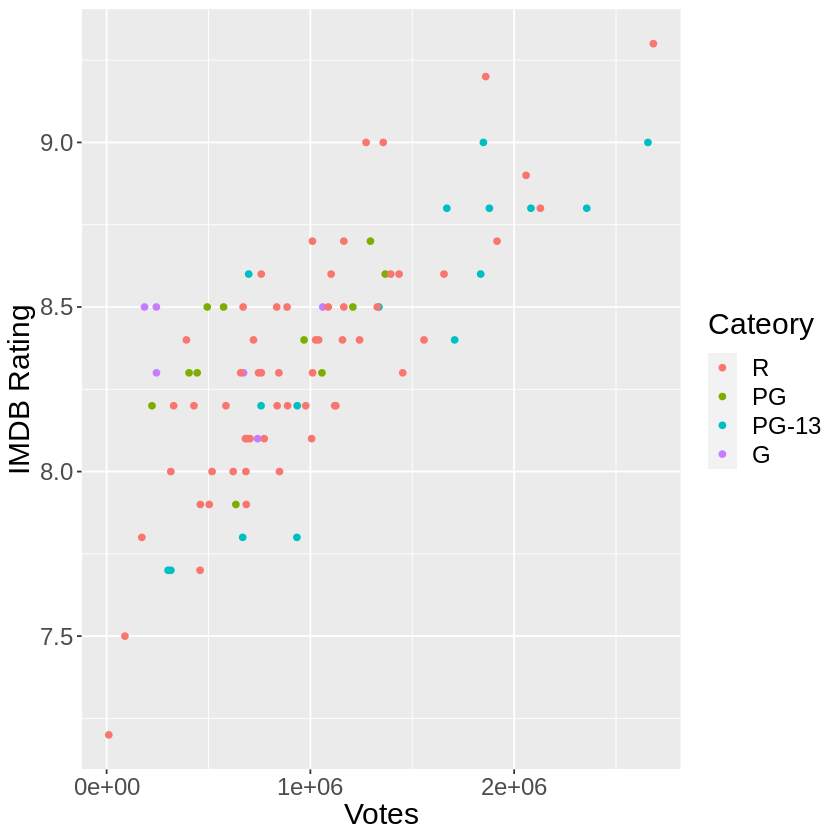

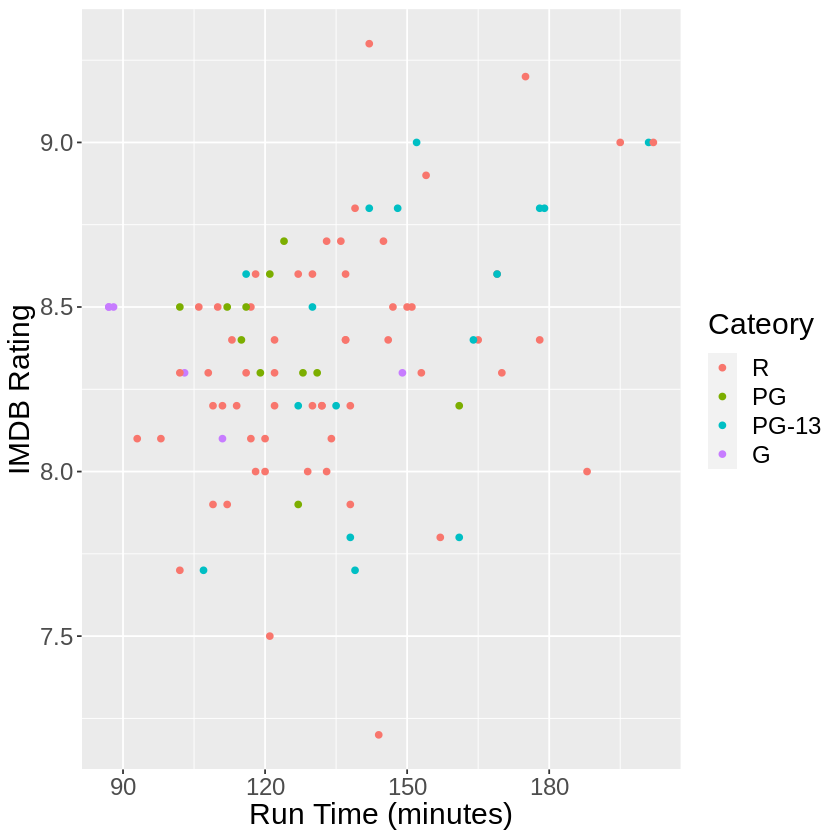

In [11]:
set.seed(9999) 

mutated_movies <- mutate(filter_movies, category = as_factor(category))
changed_movies <- mutated_movies |>
    mutate(run_time = str_replace_all(run_time, "([min])", ""))|>
    mutate(run_time = as.numeric(run_time))

knn_spec_all <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
       set_engine("kknn") |>
       set_mode("classification")

movies_data_recipe_all <- recipe(category ~ run_time + votes + imdb_rating, data = changed_movies) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

movies_fit_all <- workflow() |>
          add_recipe(movies_data_recipe_all) |>
          add_model(knn_spec_all) |>
          fit(data = changed_movies)

options(repr.plot.height = 7, repr.plot.width = 7)
movies_plot_1 <- ggplot(changed_movies, aes(x = votes, y = imdb_rating))+
    geom_point(aes(color = category))+
    labs(x = "Votes", y = "IMDB Rating", color = "Cateory")+
    theme(text = element_text(size = 18))
movies_plot_1

movies_plot_2 <- ggplot(changed_movies, aes(x = run_time, y = imdb_rating))+
    geom_point(aes(color = category))+
    labs(x = "Run Time (minutes)", y = "IMDB Rating", color = "Cateory")+
    theme(text = element_text(size = 18))
movies_plot_2

#### A table showing number of movie in different categories in the training data

In [12]:
movies_split <- initial_split(changed_movies, prop = 0.75, strata = category)  
movies_train <- training(movies_split)   
movies_test <- testing(movies_split)

movies_count <- nrow(movies_train)
movies_train |>
  group_by(category) |>
  summarize(count = n())



category,count
<fct>,<int>
R,43
PG,7
PG-13,11
G,6


#### A line graph of number of neighbors (K) and prediction accuracy

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'G'
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'G'
  Computation will proceed by ignoring those levels.



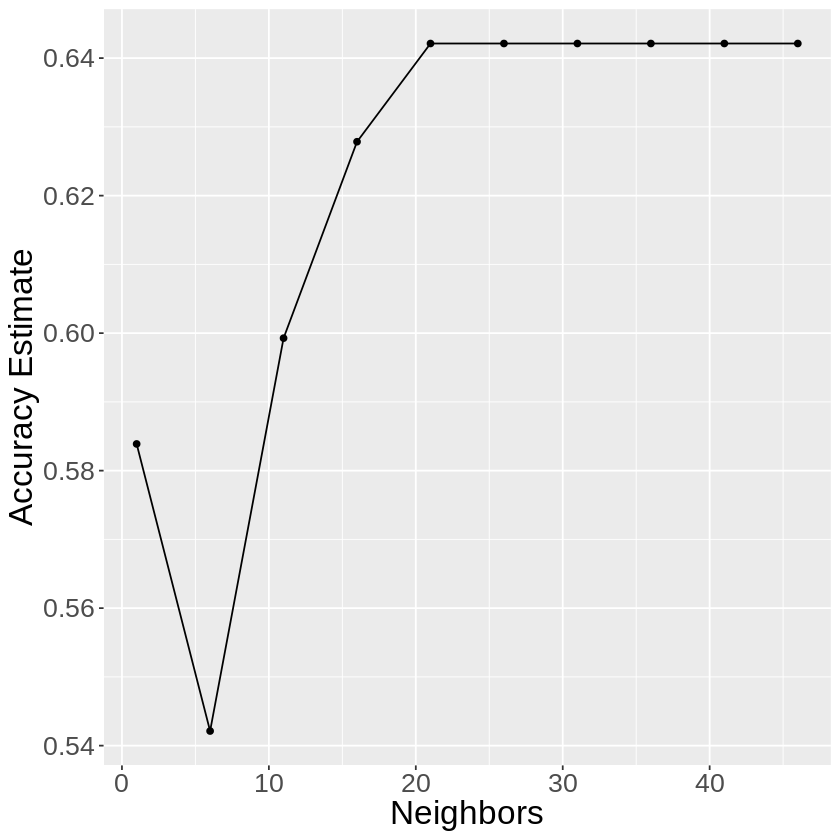

In [15]:
movies_split <- initial_split(changed_movies, prop = 0.75, strata = category)
training_movies <- training(movies_split)
testing_movies <- testing(movies_split)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

movies_recipe <- recipe(category ~ run_time + votes + imdb_rating, data = changed_movies) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

movies_vfold <- vfold_cv(training_movies, v = 5, strata = category)

grid_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

knn_results <- workflow() |>
    add_recipe(movies_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = movies_vfold, grid = grid_vals) |>
    collect_metrics()

accuracy <- knn_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

movies_plot <- ggplot(accuracy, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    theme(text = element_text(size = 20))

movies_plot

### Expected outcomes and significance